<a href="https://colab.research.google.com/github/mfilipak/AFRAC_IA/blob/main/005C_Experimentos_usando_CNN_para_representar_descri%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimento 005C
## Nesse notebook você precisa arrastar o arquivo de dados, para estudo recomendo olhar o 005B.
##Objetivo: Experimentos e reprodução de trabalhos com word embeddings usando como corpo o campo de descrição (até 120 caracteres com ou sem padding). Com foco em CNN 1D e redes siamesas. Espera-se que tenha um bom potencial de agrupar palavras por GTIN, NCM entre outros.
##Fonte dos dados: dataset público do portal da transparência - Campos de descrição e NCM.

#Referências:
* https://arxiv.org/pdf/1509.01626.pdf - Character-level Convolutional Networks for Text Classification - Esse paper é um bom ponto de partida. Tem a coparticipação do Yann LeCun, criador das CNNs.
* https://github.com/ahmedbesbes/character-based-cnn - Implementação do paper acima.
* https://www.youtube.com/watch?v=CNY8VjJt-iQ - Vídeo explicando a implementação do Ahmed para o paper.
* https://aclanthology.org/W16-1617.pdf - Não pretendo usar essa nesse experimento mas é um bom ponto de partida caso se queira usar RNN em uma rede siamesa.
* http://aclanthology.lst.uni-saarland.de/P16-1036.pdf - Abordagem semelhante usando redes siamesas para encontrar perguntas semelhantes no QUORA.
* https://www.kaggle.com/c/quora-question-pairs/discussion/33631
* https://explosion.ai/blog/quora-deep-text-pair-classification - Bom artigo embora não seja orientado a CNNs.
* https://github.com/BrambleXu/nlp-beginner-guide-keras/blob/master/char-level-cnn/char_cnn.py - Outra implementação, essa em Keras.
* https://arxiv.org/pdf/1408.5882.pdf - Classificação de sentenças, comparando CNN com outras técnicas. Um pouco outdated (2015)
*<b> https://towardsdatascience.com/character-level-cnn-with-keras-50391c3adf33 - Mais uma implementação em Keras - ponto de partida para esse notebook</b>
* https://repositorio.pucrs.br/dspace/bitstream/10923/15243/2/Measuring_Semantic_Similarity_Between_Sentences_Using_a_Siamese_Neural_Network.pdf - Paper de alguns autores Brasileiros da PUC RS usa rede siamesa com arquitetura GRU.


#Dica: Altere o tipo de runtime para usar GPU, os treinos desse notebook são relativamente pesados para rodar em CPU.<br><br>
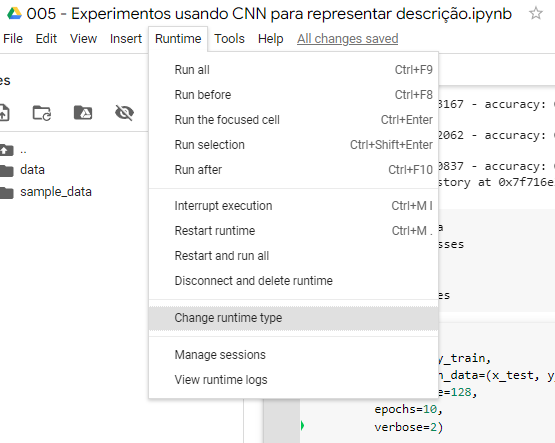

In [1]:
import requests
import os
import pandas as pd

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, Embedding, Activation, Flatten, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
#Copia os dados das NFEs do portal da cidadância pro drive virtual.
import requests  

DATA_FILE = "AFRAC-20220506.zip"
df = pd.read_csv(DATA_FILE, encoding='utf-8-sig',sep=";", decimal=',')
#(csv_file_name,encoding='utf-8-sig', sep =';', decimal=',', index=False)
print("O dataframe completo contém:",len(df),"linhas")

df3 = df[['Data de Emissão - Documento Fiscal','Descrição do Item', 'NCM', 'GTIN/EAN Comercial']]
df3.columns = ["DATA", "DESCR", "NCM", "GTIN"]
#df3 = df3[df3["NCM"]!=-1] #Filtrando NCMs = -1

text_lengths = np.array([len(_) for _ in df3['DESCR']])
df3 = df3[text_lengths>=3]

#Caso queira eliminar as repetições rodar a linha abaixo
df3 = df3.drop_duplicates(subset=["DESCR", "NCM", "GTIN"])
print("O dataframe sem repetiçoes contém:",len(df3),"linhas")
df3[:1]

O dataframe completo contém: 1363510 linhas
O dataframe sem repetiçoes contém: 1105737 linhas


,DATA,DESCR,NCM,GTIN
0,2022-03-05,!!!!! AGUA COM GAS 500ML,22021000,-1


In [3]:
descs = [_.lower() for _ in df3["DESCR"]]
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(descs)
print(tk.word_index)
print(f"{len(tk.word_index)} caracteres.")
print("".join(sorted([_ for _ in tk.word_index])))
descs = [_+(120-len(_))*" " for _ in descs]
df3["DESCR_NORM"] = descs
df3[-5:]

{'UNK': 1, ' ': 2, 'a': 3, 'o': 4, 'e': 5, 'r': 6, 'i': 7, 'c': 8, 'l': 9, 's': 10, 't': 11, 'n': 12, 'm': 13, '0': 14, 'p': 15, 'g': 16, 'd': 17, 'u': 18, 'b': 19, '1': 20, 'f': 21, 'h': 22, '2': 23, '5': 24, 'v': 25, '3': 26, 'k': 27, '4': 28, '.': 29, 'x': 30, '6': 31, '8': 32, '-': 33, '7': 34, '9': 35, 'j': 36, 'z': 37, '/': 38, 'y': 39, 'q': 40, 'w': 41, ',': 42, ':': 43, '(': 44, ')': 45, '_': 46, '#': 47, '+': 48, '*': 49, '%': 50, '"': 51, "'": 52, 'ç': 53, '&': 54, 'ã': 55, ';': 56, ']': 57, '[': 58, '$': 59, 'á': 60, '\\': 61, '|': 62, 'é': 63, 'º': 64, 'ó': 65, '!': 66, '=': 67, 'í': 68, 'ê': 69, '?': 70, '>': 71, '@': 72, '¿': 73, '°': 74, 'ú': 75, '\xa0': 76, 'ô': 77, 'â': 78, '`': 79, 'à': 80, 'õ': 81, 'ï': 82, 'ª': 83, '²': 84, '{': 85, '<': 86, '~': 87, 'è': 88, '§': 89, 'ø': 90, 'ñ': 91, '³': 92, 'û': 93, 'ù': 94, '\xad': 95, '}': 96, '\x81': 97, 'ä': 98, 'ü': 99, '¶': 100, '^': 101, '€': 102, '¹': 103, 'µ': 104, '®': 105, '¡': 106}
106 caracteres.
 !"#$%&'()*+,-./012

,DATA,DESCR,NCM,GTIN,DESCR_NORM
1363505,2022-03-05,ÓLEO DE SEMENTE DE ABÓBORA CAP. 80/1000mg - GL...,21069030,7898568353873,óleo de semente de abóbora cap. 80/1000mg - gl...
1363506,2022-03-05,Óleo de Soja Liza 900Ml,15079011,7896036090244,óleo de soja liza 900ml ...
1363507,2022-03-05,Óleo Essencial Hortelã BioEssência - 10ml,33012990,7898937573192,óleo essencial hortelã bioessência - 10ml ...
1363508,2022-03-05,Óleo Essencial Lavanda Francesa BioEssência - ...,33012990,7898937573246,óleo essencial lavanda francesa bioessência - ...
1363509,2022-03-05,Óleo Motor 20w50 Havoline,27101932,-1,óleo motor 20w50 havoline ...


In [4]:
df3["DESCR_NORM"].values

array(['!!!!! agua com gas 500ml                                                                                                ',
       '!!!!! agua sem gas 500ml                                                                                                ',
       '!agua sanitaria                                                                                                         ',
       ...,
       'óleo essencial hortelã bioessência - 10ml                                                                               ',
       'óleo essencial lavanda francesa bioessência - 10ml                                                                      ',
       'óleo motor 20w50 havoline                                                                                               '],
      dtype=object)

https://classificadorfiscal.com.br/uploads/1/0/6/1/106125045/secaoecap.html

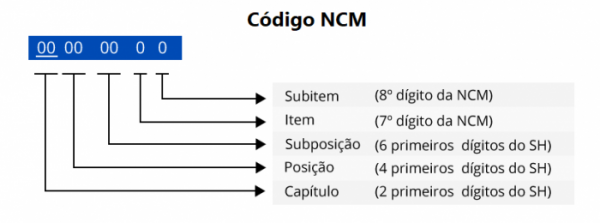

In [5]:
capitulos = [ int(f"{_:08}"[:2]) for _ in df3["NCM"] ]
df3["CAPITULO"] = capitulos
print(f"Capítulos encontrados no NCM: {len(df3['CAPITULO'].unique())}")

Capítulos encontrados no NCM: 97


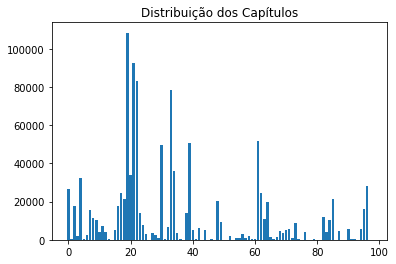

In [6]:
#df3.count("CAPITULO")
plt.title("Distribuição dos Capítulos")
plt.bar(df3["CAPITULO"].value_counts().index, df3["CAPITULO"].value_counts().values)
plt.show()

In [7]:
# Convert string to index
X_sequences = tk.texts_to_sequences(descs)
X = np.array(X_sequences, dtype='float32')
X.shape

(1105737, 120)

In [9]:
Y = to_categorical(capitulos, num_classes=100)
Y.shape

(1105737, 100)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [11]:
X_train.shape, y_train.shape

((995163, 120), (995163, 100))

In [12]:
vocab_size = len(tk.word_index)
vocab_size

106

In [13]:
embedding_weights = [] #(71, 70)
embedding_weights.append(np.zeros(vocab_size)) # first row is pad

for char, i in tk.word_index.items(): # from index 1 to 70
    onehot = np.zeros(vocab_size)
    onehot[i-1] = 1
    embedding_weights.append(onehot)
embedding_weights = np.array(embedding_weights)

In [14]:
print(embedding_weights.shape) # first row all 0 for PAD, 69 char, last row for UNK
embedding_weights

(107, 106)


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [15]:
# parameter 
input_size = 120
embedding_size = 106
#conv_layers = [[256, 7, 3], 
#               [256, 7, 3], 
#               [256, 3, -1], 
#               [256, 3, -1], 
#               [256, 3, -1], 
#               [256, 3, 3]]


conv_layers = [[256, 7, 3], 
               [64, 7, 3], 
               [64, 3, -1], 
               [64, 3, -1], 
               [64, 3, -1]]


#fully_connected_layers = [1024, 1024]
fully_connected_layers = [256, 128]
num_of_classes = 100
dropout_p = 0.5
optimizer = 'adam'
loss = 'categorical_crossentropy'

In [16]:
# Embedding layer Initialization
embedding_layer = Embedding(vocab_size+1, 
                            embedding_size,
                            input_length=input_size,
                            weights=[embedding_weights])

In [20]:
# Model 

# Input
inputs = Input(shape=(input_size,), name='input', dtype='int64')  # shape=(?, 1014)
# Embedding 
x = embedding_layer(inputs)
# Conv 
for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x) 
    x = Activation('relu')(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x) # Final shape=(None, 34, 256)
x = Flatten()(x) # (None, 8704)
# Fully connected layers 
for dense_size in fully_connected_layers:
    x = Dense(dense_size, activation='relu')(x) # dense_size == 1024
    x = Dropout(dropout_p)(x)
# Output Layer
predictions = Dense(num_of_classes, activation='softmax')(x)
# Build model
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) # Adam, categorical_crossentropy
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 120)]             0         
                                                                 
 embedding (Embedding)       (None, 120, 106)          11342     
                                                                 
 conv1d_5 (Conv1D)           (None, 114, 256)          190208    
                                                                 
 activation_5 (Activation)   (None, 114, 256)          0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 38, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 32, 64)            114752    
                                                           

In [18]:
x_train = X_train[:]
x_test = X_test[:]


In [21]:
try:
  del history
except:
  None

In [131]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy']) # Adam, categorical_crossentropy

In [ ]:
# Training
new_history = model.fit(x_train, y_train[:len(x_train)],
          validation_data=(x_test, y_test[:len(x_test)]),
          batch_size=128,
          epochs=5,
          verbose=1)

try:
  for k in history.keys():
    history[k]+=new_history.history[k]
except:
  history = new_history.history

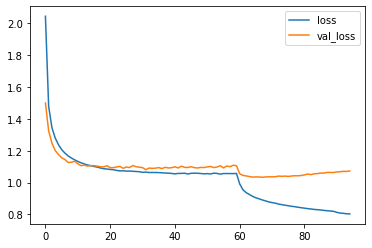

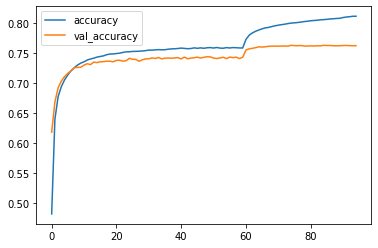

In [119]:
for [k1,k2] in [ ["loss", "val_loss"], ["accuracy", 'val_accuracy'] ]:
  plt.plot(history[k1], label=k1)
  plt.plot(history[k2], label=k2)
  plt.legend()
  plt.show()
#  print(k)

In [120]:
model.save("CNN1D_DESC_NCM_BIGDATA.H5", save_format="h5")

In [121]:
pred = model.predict(X)

In [122]:
df3["CAP_PRED"] = [ np.argmax(_) for _ in pred[:]]

In [123]:
1 - len(df3[df3["CAPITULO"] != df3["CAP_PRED"]])/len(df3)

0.8110789455358733

In [130]:
df_diffs = df3[df3["CAPITULO"] != df3["CAP_PRED"]]
df_diffs[df_diffs["CAPITULO"]==16][:50]

,DATA,DESCR,NCM,GTIN,DESCR_NORM,CAPITULO,CAP_PRED
177,2022-03-05,##16042030#ROLLMOPS 620G,16042030,-1,##16042030#rollmops 620g ...,16,19
7345,2022-03-05,#MORTADELA,16010000,7891515356736,#mortadela ...,16,21
9937,2022-03-05,+ BARBECUE,16025000,-1,+ barbecue ...,16,21
9938,2022-03-05,+ BURGER VEGGIE,16025000,-1,+ burger veggie ...,16,21
9944,2022-03-05,+ MAIONESE,16025000,-1,+ maionese ...,16,19
9948,2022-03-05,+ SALADA,16025000,-1,+ salada ...,16,21
12334,2022-03-05,01. CARNE,16025000,-1,01. carne ...,16,21
12335,2022-03-05,01. CHEESEBURGER,16025000,-1,01. cheeseburger ...,16,21
12338,2022-03-05,01. FRITAS,16025000,-1,01. fritas ...,16,21
12339,2022-03-05,01. JANELA MELT,16025000,-1,01. janela melt ...,16,21


In [90]:
import tensorflow as tf

In [110]:
m2 = tf.keras.models.load_model("CNN1D_DESC_NCM_BIGDATA.H5", compile=False)

In [92]:
query = "refrigeramte coca cola"
np.argmax(m2.predict(np.array(tk.texts_to_sequences([query+" "*(120-len(query))])))[0])

22

In [111]:
query = "refrigerante coca cola"
np.argmax(m2.predict(np.array(tk.texts_to_sequences([query+" "*(120-len(query))])))[0])

22

In [41]:
query = "refrigerant coca cola"
np.argmax(m2.predict(np.array(tk.texts_to_sequences([query+" "*(120-len(query))])))[0])

22

In [42]:
query = "refrigerante coca"
np.argmax(m2.predict(np.array(tk.texts_to_sequences([query+" "*(120-len(query))])))[0])

22

In [43]:
query = "guaraná pet 2l"
np.argmax(m2.predict(np.array(tk.texts_to_sequences([query+" "*(120-len(query))])))[0])

22

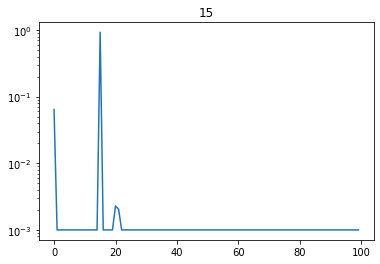

In [112]:
query = "óleo de soja"
pred = m2.predict(np.array(tk.texts_to_sequences([query+" "*(120-len(query))])))[0]
aux = pred.copy()
aux[aux<0.001] = 0.001
plt.yscale("log")
plt.title(np.argmax(pred))
plt.plot(aux)
plt.show()

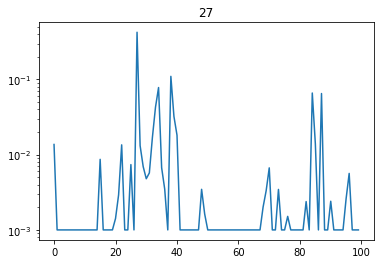

In [113]:
query = "óleo mineral"
pred = m2.predict(np.array(tk.texts_to_sequences([query+" "*(120-len(query))])))[0]
aux = pred.copy()
aux[aux<0.001] = 0.001
plt.yscale("log")
plt.title(np.argmax(pred))
plt.plot(aux)
plt.show()

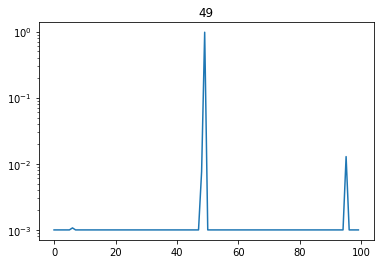

In [114]:
query = "física quântica 5a edição"
pred = m2.predict(np.array(tk.texts_to_sequences([query+" "*(120-len(query))])))[0]
aux = pred.copy()
aux[aux<0.001] = 0.001
plt.yscale("log")
plt.title(np.argmax(pred))
plt.plot(aux)
plt.show()

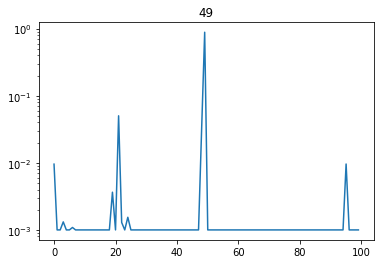

In [115]:
query = "física quântica 5a edição editora bife de alcatra"
pred = m2.predict(np.array(tk.texts_to_sequences([query+" "*(120-len(query))])))[0]
aux = pred.copy()
aux[aux<0.001] = 0.001
plt.yscale("log")
plt.title(np.argmax(pred))
plt.plot(aux)
plt.show()

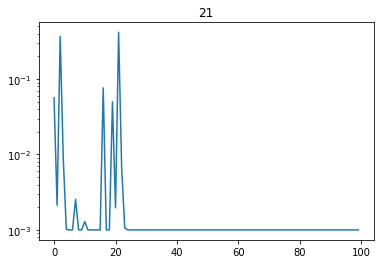

In [116]:
query = "bife de alcatra"
pred = m2.predict(np.array(tk.texts_to_sequences([query+" "*(120-len(query))])))[0]
aux = pred.copy()
aux[aux<0.001] = 0.001
plt.yscale("log")
plt.title(np.argmax(pred))
plt.plot(aux)
plt.show()